# **Scratch Detection**

The motivation behind the work represented here, is to detect scartches on wafers and mark wafers as with scratches or without.  \
A scratch on a wafer is caused by a mechanical/human error in the manufacturing process. A scratch is an elongated line of 'bad dies' across the wafer, mostly with high aspect ratio, though there may still be 'good dies' along the scratch that will be needed to be removed anyway, and marked as part of the scratch. In addition to scratches, there are also many 'bad dies', though most of those are not part of a scratch necessarily.



Each Die on a wafer is represented in the dataset as a lin, where the wafer name (WaferName) is specified (same as ID), X coordinate (DieX) and Y coordinate (DieY), and wether the Die is good or not (IsGoodDie).  \
In addition, in the train dataset, there's an additional column that specifies wether a specific die is part of a scratch or not (IsScratchDie).  



There are more explanations along the notebook, motivation, ideas and implementations based on business goals and efficiency 

**_Note:_** There are comment cells that I kept to show the stuff I tested though not selected as part of the result, but wanted to showcase nonetheless. 

These are big DL models and I didn't want the unused ones to run as well, if you choose to test it.

# **Table of Contents**

>[Start](#scrollTo=TSrTU38hg7t6)

>[Solution](#scrollTo=Np_ytDIGg7uL)

>>[Exploring the data](#scrollTo=v6H19zG-g7uN)

>>[Building the structure](#scrollTo=TEUiToAGg7uP)

>>[Building U-Net like model](#scrollTo=Qq29-jIug7uY)

>>>[First model](#scrollTo=mJfmLaQLg7uY)

>>>[Second model](#scrollTo=Qhtk0kO_lmyS)

>>[Final Model Evaluation](#scrollTo=BsH_ketAnpD_)

>[Additional Thoughts](#scrollTo=WpGNdJ9OiAFD)

>[Making Predictions](#scrollTo=O-lDYoSb0rH-)



# Start 

Imports

In [157]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Load Data

In [158]:
#load zip file
# from google.colab import drive
# drive.mount('/content/drive')
# zf = zipfile.ZipFile('/content/drive/MyDrive/data.zip')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [159]:
#load zip file
zf = zipfile.ZipFile('data.zip') 

In [160]:
#load train data
df_wafers = pd.read_csv(zf.open('df_wafers.csv'))
df_wafers.head()

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,3b2e28,0,12,False,False
1,3b2e28,0,13,True,False
2,3b2e28,0,14,False,False
3,3b2e28,0,15,True,False
4,3b2e28,0,16,True,False


In [161]:
#load test data
df_wafers_test = pd.read_csv(zf.open('df_wafers_test.csv'))
df_wafers_test.head()

,WaferName,DieX,DieY,IsGoodDie
0,5a6ad6,0,12,False
1,5a6ad6,0,13,True
2,5a6ad6,0,14,True
3,5a6ad6,0,15,True
4,5a6ad6,0,16,True


Plot wafer maps (both test or train)

In [162]:
def plot_wafer_maps(wafer_df_list, figsize, labels = True):
    """
    Plot wafer maps given a dataset of coordinate map of wafers. 
    With option to print either test or train data (given labels)

    Parameters
    ----------
    wafer_df_list: list, The list of df's of the wafers
    figsize: int, the size of the figsize height 
    labels: boolean, Whether to show the layer of labels (based on column 'IsScratchDie')
    
    Returns
    -------
    None
    """
    def plot_wafer_map(wafer_df, ax, map_type):
        wafer_size = len(wafer_df)
        s = 2**17/(wafer_size)
        if map_type == 'Label':
            mes = 'Scratch Wafer' if (wafer_df['IsScratchDie'] == True).sum()>0 else 'Non-Scratch Wafer'
        else:
            mes = 'Yield: ' + str(round((wafer_df['IsGoodDie']).sum()/(wafer_df['IsGoodDie']).count(), 2)) 
        
        ax.set_title(f'{map_type} | Wafer Name: {wafer_df["WaferName"].iloc[0]}, \nSum: {len(wafer_df)} dies. {mes}', fontsize=20)
        ax.scatter(wafer_df['DieX'], wafer_df['DieY'], color = 'green', marker='s', s = s)

        bad_bins = wafer_df.loc[wafer_df['IsGoodDie'] == False]
        ax.scatter(bad_bins['DieX'], bad_bins['DieY'], color = 'red', marker='s', s = s)
        
        if map_type == 'Label':
            scratch_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == False)]
            ax.scatter(scratch_bins['DieX'], scratch_bins['DieY'], color = 'blue', marker='s', s = s)

            ink_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == True)]
            ax.scatter(ink_bins['DieX'], ink_bins['DieY'], color = 'yellow', marker='s', s = s)

            ax.legend(['Good Die', 'Bad Die', 'Scratch Die', 'Ink Die'], fontsize=8)
        else:
            ax.legend(['Good Die', 'Bad Die'], fontsize=8)

        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False) 
    
    import numpy as np
    import matplotlib.pyplot as plt
    
    if labels:
        fig, ax = plt.subplots(2, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize*2))
        for idx1, wafer_df in enumerate(wafer_df_list):
            for idx2, map_type in enumerate(['Input', 'Label']):
                plot_wafer_map(wafer_df, ax[idx2][idx1], map_type)
    else:
        fig, ax = plt.subplots(1, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize))
        for idx, wafer_df in enumerate(wafer_df_list):
            plot_wafer_map(wafer_df, ax[idx], 'Input')

    plt.show()

Train data visualization:

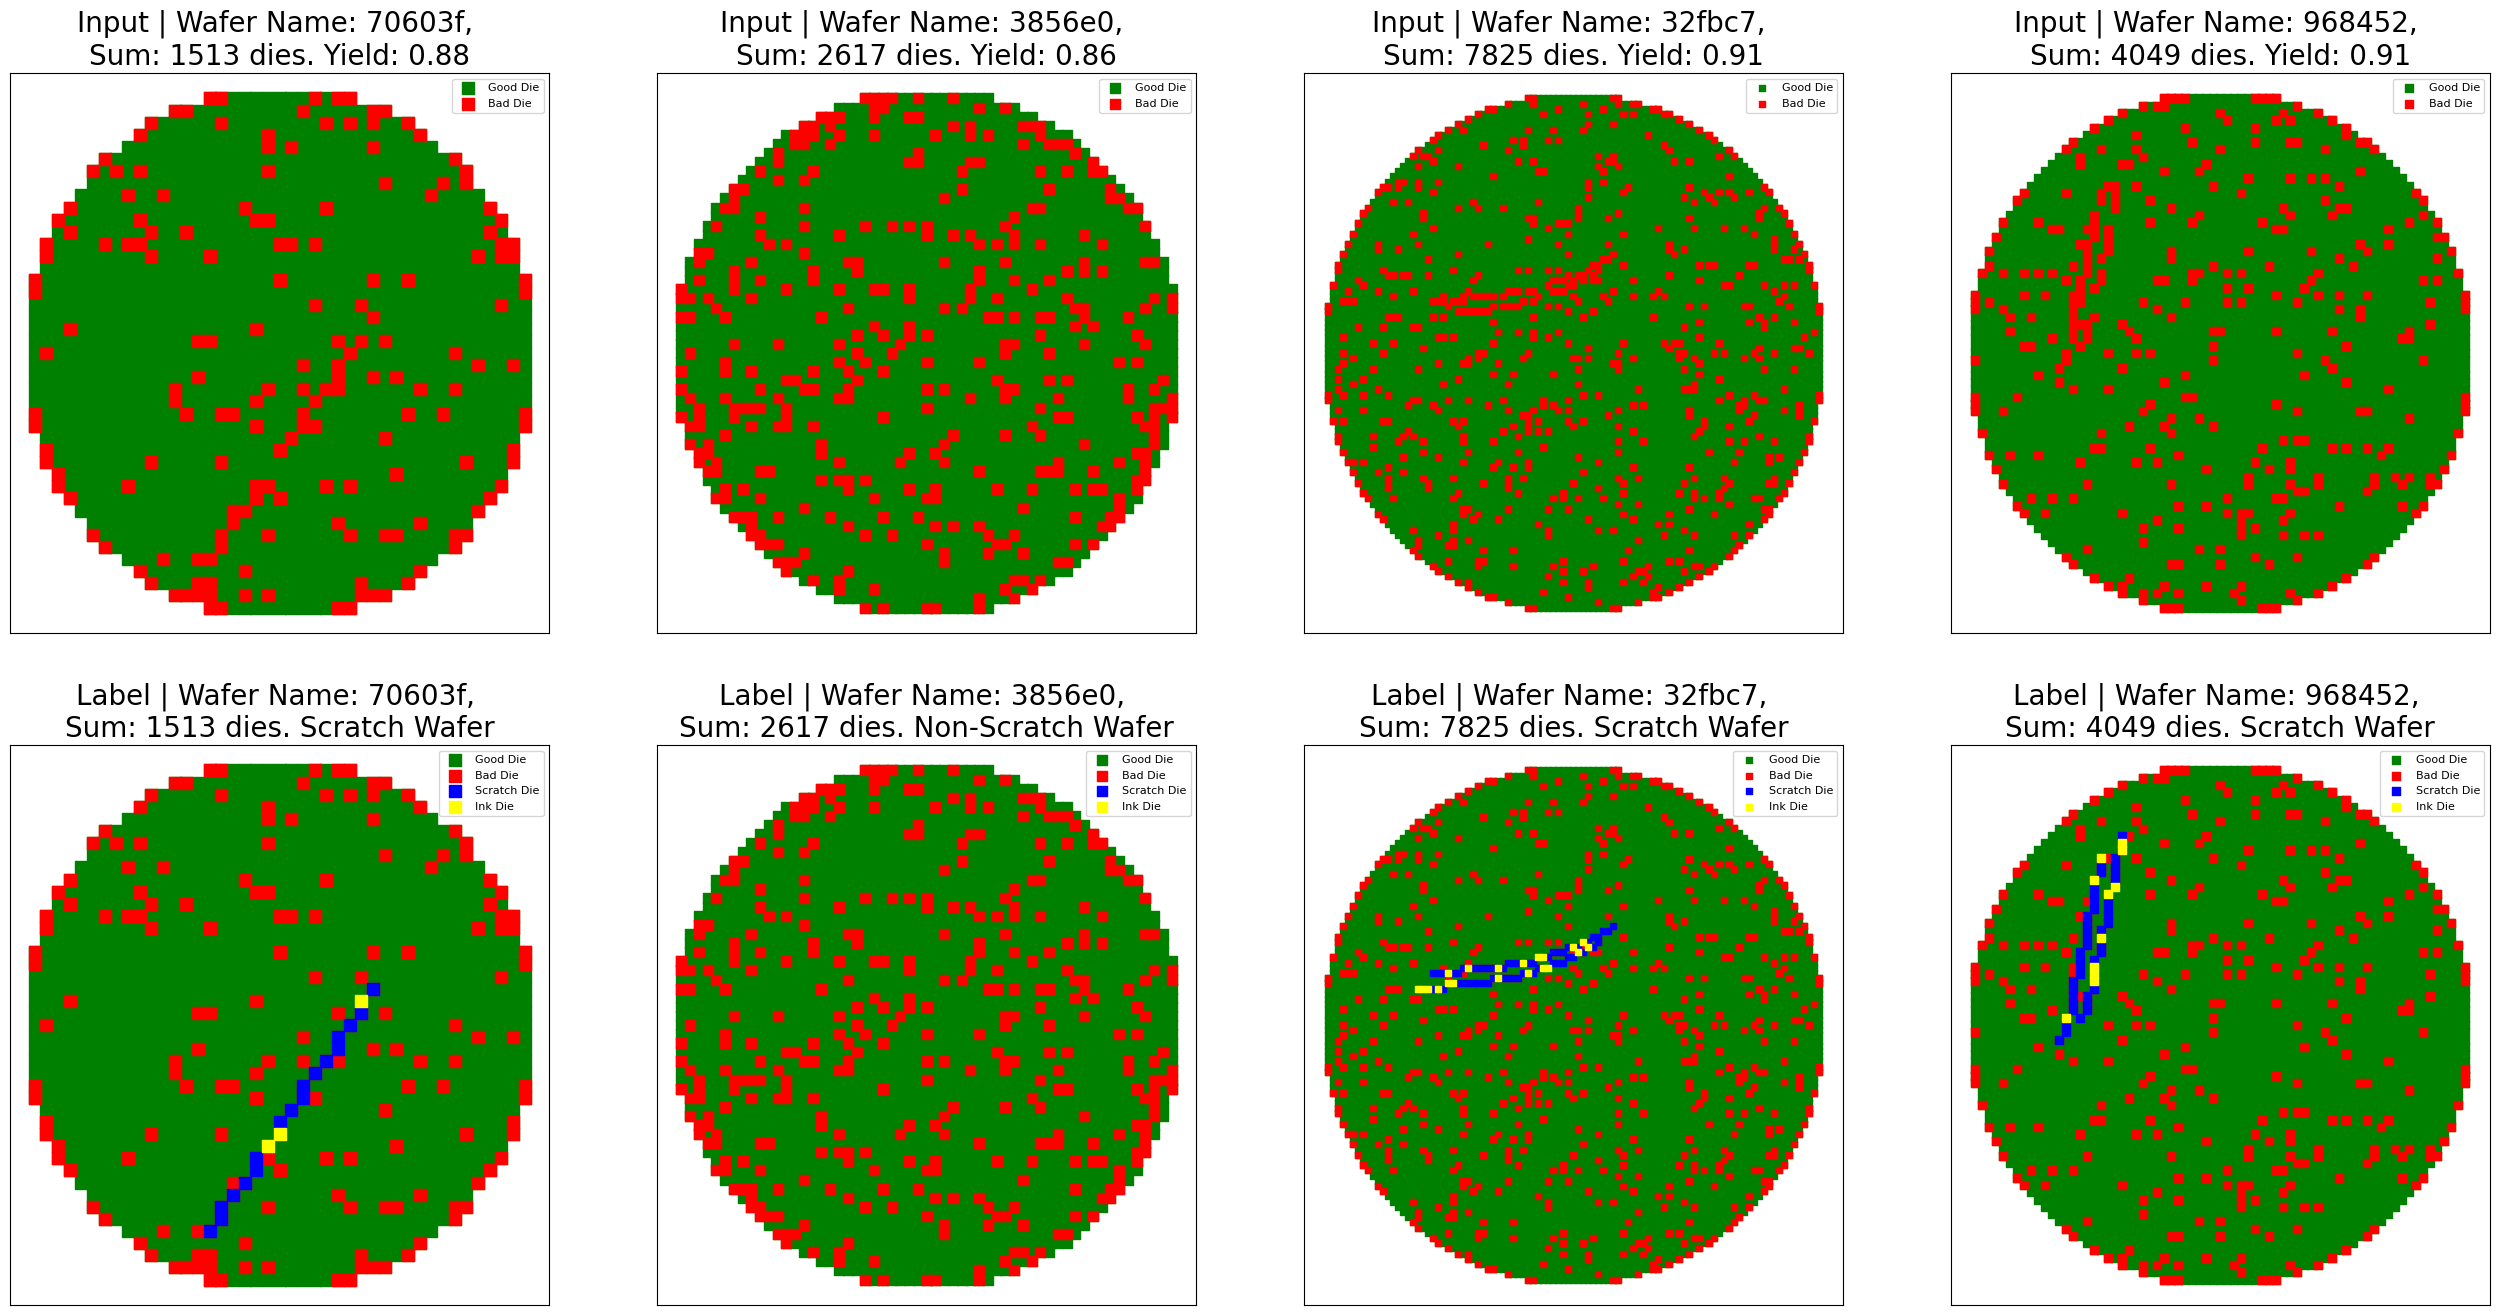

In [163]:
n_samples = 4
list_sample_train = [df_wafers.groupby('WaferName').get_group(group) for group in df_wafers['WaferName'].value_counts().sample(n_samples).index]
plot_wafer_maps(list_sample_train, figsize = 8, labels = True)

Test data visualization:

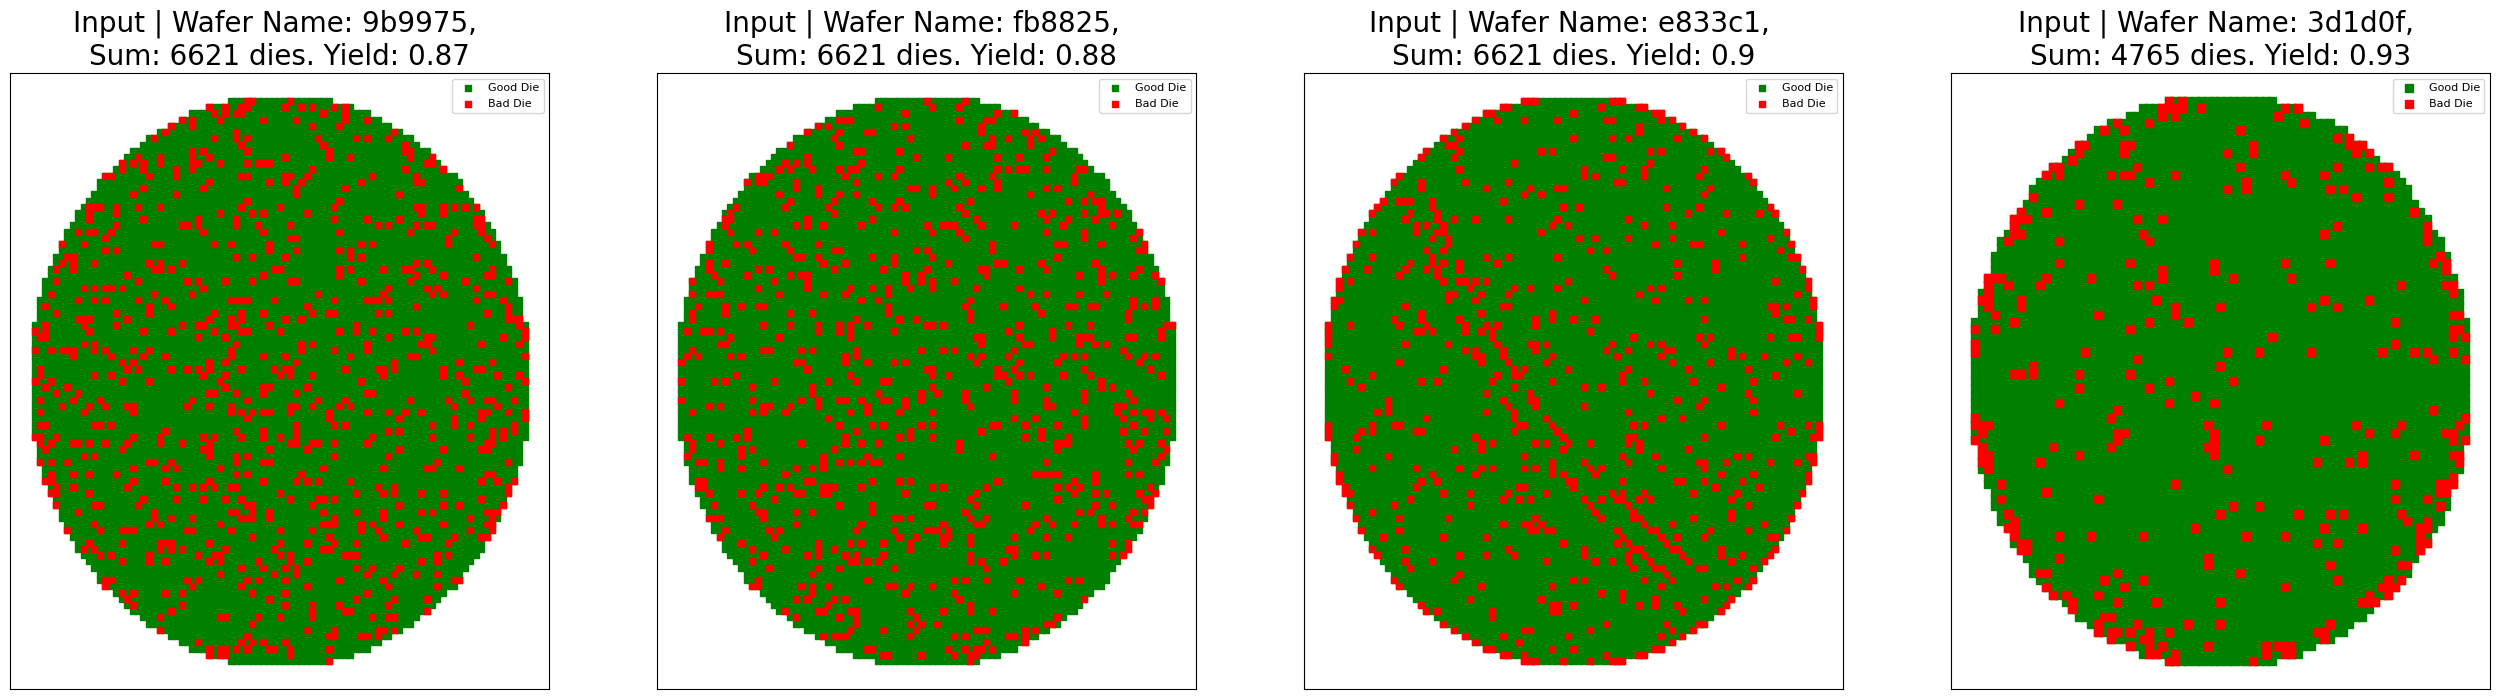

In [164]:
list_sample_test = [df_wafers_test.groupby('WaferName').get_group(group) for group in df_wafers_test['WaferName'].value_counts().sample(n_samples).index]
plot_wafer_maps(list_sample_test, figsize = 8, labels = False)

[Back to top](#scrollTo=DoWRBGFU2AFV&line=1&uniqifier=1)

# Solution

The main goal is to classify individual dies as scratch or not. 

This problem cannot/preferably not be solved/approached to as a tabular problem. \
Transforming it to a binary image segmentation problem may be better.


Business goals notes:
- Automation - the goal is to perform this procedure in a faster time and save the costs of the test.
- Quality - find scratches but reduce inking (minimal as possible). 
- Prediction Level - add binary classification per image (included in the helper function already), because sometimes it will help to get a classification at the wafer level, (binary classification, is there a scratch on this wafer or not?) because there are manufacturers who return scratched wafers to the factory. 

## Exploring the data


Transforming the tabular data to binary images in order to work on this problem as a segmentation problem on images, semantic segmentation.

In [165]:
# Train
df_wafers.head()

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,3b2e28,0,12,False,False
1,3b2e28,0,13,True,False
2,3b2e28,0,14,False,False
3,3b2e28,0,15,True,False
4,3b2e28,0,16,True,False


In [166]:
# Test
df_wafers_test.head()

,WaferName,DieX,DieY,IsGoodDie
0,5a6ad6,0,12,False
1,5a6ad6,0,13,True
2,5a6ad6,0,14,True
3,5a6ad6,0,15,True
4,5a6ad6,0,16,True


I'm checking the size of the different wafers to infer or calculate the amount of padding needed to get to uniform image sizes. \
I'd rather use padding instead of cutting the images to smaller images.

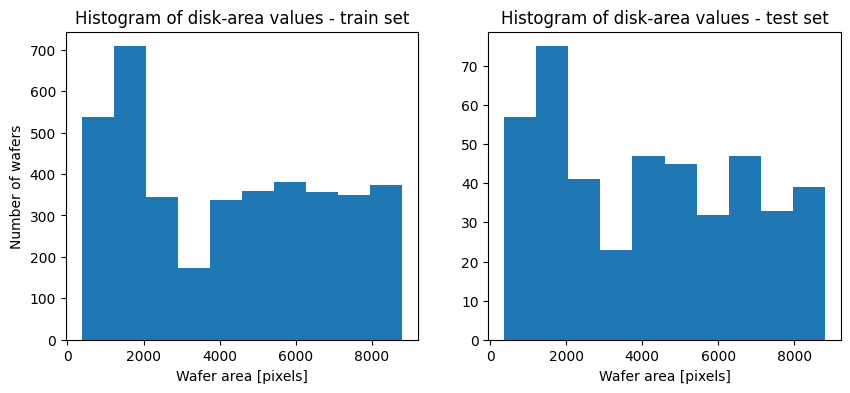

In [167]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df_wafers['WaferName'].value_counts())
plt.title("Histogram of disk-area values - train set"); plt.xlabel("Wafer area [pixels]")  ;  plt.ylabel("Number of wafers")

plt.subplot(1,2,2)
plt.hist(df_wafers_test['WaferName'].value_counts())
plt.title("Histogram of disk-area values - test set"); plt.xlabel("Wafer area [pixels]")  ;  
plt.show()

No outliers can be seen, the maximal size will be used.

In [168]:
image_size = max(df_wafers['WaferName'].value_counts().max(), df_wafers_test['WaferName'].value_counts().max()) # NOTE check if this is 'legal' (measuring size of test set)
print("Maximal image size: " + str(image_size))

Maximal image size: 8797


From the nature of the task, there is a huge **imbalance** between the scratch/no scratch classes \
Train set imbalance is shown below

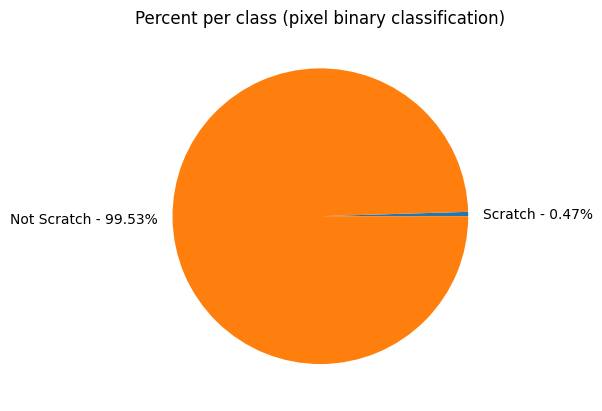

In [169]:
n_True = df_wafers["IsScratchDie"].sum() 
n_Overall = len(df_wafers["IsScratchDie"])
n_False = n_Overall - n_True

plt.figure()
plt.pie([n_True,n_False], labels = [f"Scratch - {round(100*n_True/n_Overall,2)}%",f"Not Scratch - {round(100*n_False/n_Overall,2)}%"])
plt.title("Percent per class (pixel binary classification)")
plt.show()

Checking how many scratched wafers there are in the training dataset

There are 1926 scratched wafers out of 3920 wafers overall (0.49%) in the training dataset


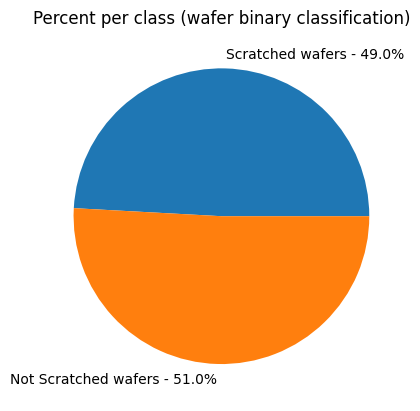

In [170]:
grps = df_wafers.groupby('WaferName', sort = False)
IsScratchWafer_lst = []
for grp in grps.groups:
    sub_df = grps.get_group(grp)
    val = 1 if (sub_df['IsScratchDie'] == True).sum()>0 else 0
    IsScratchWafer_lst.append(val)
print(f"There are {sum(IsScratchWafer_lst)} scratched wafers out of {len(IsScratchWafer_lst)} wafers overall ({np.round(sum(IsScratchWafer_lst)/len(IsScratchWafer_lst),2)}%) in the training dataset")  

plt.figure()
plt.pie([sum(IsScratchWafer_lst),len(IsScratchWafer_lst) - sum(IsScratchWafer_lst)], 
         labels = [f"Scratched wafers - {100*np.round(sum(IsScratchWafer_lst)/len(IsScratchWafer_lst),2)}%",f"Not Scratched wafers - {100*np.round(1-sum(IsScratchWafer_lst)/len(IsScratchWafer_lst),2)}%"])
plt.title("Percent per class (wafer binary classification)")
plt.show()

[Back to top of: Exploring the data](#scrollTo=v6H19zG-g7uN)

[Back to top](#scrollTo=DoWRBGFU2AFV&line=1&uniqifier=1)

## Building the structure

Creating the Wafer class with toImage method to transform the tabular data to binary arrays (images) \
toImage method has been revised multiple times to decrease execution time

In [171]:
DIAMETER = int(round(np.sqrt(image_size/np.pi)*2)) # Calculate diameter from area of a disk/circle
im_shape = (DIAMETER,DIAMETER) # Diameter = 106
im_shape = (128,128) # I increased the 0-padding to 128 to fix NNET dimensions not aligning at the end and not risk 'knowing' test image size

class Wafer:
    """Wafer class
    Attributes (in creating time)
    ----------
    asTable: The wafer data as given in the test df

    waferArea: The area of the wafer
    """
    def __init__(self, sub_df): 
        # self.waferName = waferName 
        self.asTable = sub_df
        self.waferArea = len(sub_df) # area of the given wafer-disk shaped == number of dies in the wafer
        # self.diameter = int(round(np.sqrt(self.waferArea/np.pi)*2)) # Calculate diameter from area of a disk/circle NOTE UNUSED

    def toImage(self, isTrain = False):
        """Transforms the tabular data to a binary matrix that can be shown as a binary image.

        Attributes
        ----------
        # asImage: This funtion saves the resulted binary matrix as an attribute

        Parameters
        ----------
        isTrain: default = False ;
            Whether to transform labels or not

        Returns
        -------
        image: returns the resulted binary matrix of the wafer
            NOTE maybe change it to self and just save the attribute without returning the matrix
        
        -(Only when isTrain is True)-
        label_image: returns the resulted binary matrix of the wafer's label
        """
        image = np.zeros(im_shape) 
        label_image = np.zeros(im_shape)

        if isTrain is True:
            for x,y,pix,lab in zip(self.asTable["DieX"],self.asTable["DieY"],self.asTable["IsGoodDie"],self.asTable["IsScratchDie"]):
                image[x,y] = not pix # Axis are different in images, -> NOTE Negative image of IsGoodDie bool
                # NOTE TO SELF: True image = image[len(image) - row["DieY"] ,row["DieX"]]; Example - Bottom right: in axis = (0,0) , in image = image[len(image),0] 
                label_image[x,y] = lab
            
            return image, label_image
        
        else:
            for x,y,pix in zip(self.asTable["DieX"],self.asTable["DieY"],self.asTable["IsGoodDie"]):
                image[x,y] = not pix 

            return image

Function for transforming the datasets to images \
transform_dataset function has been revised multiple times to decrease execution time

In [172]:
def transform_dataset(df, isTrain = False):
    """Transforms the given dataset into images, if the dataset is train set - also transforms the labels into images
    Parameters
    ----------
    df: DataFrame
        Input data set

    isTrain: default = False ;
        Whether to transform labels or not

    Returns
    -------
    DS: List of arrays
        Each array is a wafer (not IsGoodDie column) from the given DataFrame as an image

    -(Only when isTrain is True)-
    labels: List of arrays 
        Each array is a wafer's labels (IsScratchDie column) from the given DataFrame as an image
    """
    DS = []

    grps = df.groupby('WaferName', sort = False)

    if isTrain is True:
        labels = []
        
        for grp in grps.groups:
            sub_df = grps.get_group(grp)

            image, label_image = Wafer(sub_df).toImage(isTrain = isTrain)
            DS.append(image)
            labels.append(label_image)

        print("Train set was transformed")
        return DS, labels
            
        
    else:
        for grp in grps.groups:
            sub_df = grps.get_group(grp)

            DS.append(Wafer(sub_df).toImage())

        print("Test set was transformed")
        return DS

Transform datasets to images 

In [173]:
x_train, y_train = transform_dataset(df_wafers, isTrain = True) 

print('Shape of x_train is:', np.shape(x_train))
print('Shape of y_train is:', np.shape(y_train))

Train set was transformed
Shape of x_train is: (3920, 128, 128)
Shape of y_train is: (3920, 128, 128)


Show train set images and labels

In [174]:
# try_im_idx = 8

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(x_train[try_im_idx])

# plt.subplot(1,2,2)
# plt.imshow(y_train[try_im_idx])
# plt.show()

[Back to top of: Building the structure](#scrollTo=TEUiToAGg7uP)

[Back to top](#scrollTo=DoWRBGFU2AFV&line=1&uniqifier=1)

## Building U-Net like model

Semantic segmentation, FCN / CNN, further research showed that U-Net will be suitable here. 

Training a NNET on images require uniform sizes, therefore, I'll be padding the images with zeros, technicaly - padding with "not IsGoodDie" bool values. 

It doesn't realy matter whether the padding is included or not, I'll not be retrieving any of the added pixel as they do not exist in the original dataset.

I'd rather padding rather than spliting images to smaller ones here, in order to not risk losing the pixel order and the spatial information.

### First model
Based on: https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

Helper functions

In [175]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

Build the U-Net model

Largest model - Unused but was tested

In [176]:
# def build_unet_model():
#  # inputs
#    inputs = layers.Input(shape=(*im_shape,1))

#    # encoder: contracting path - downsample
#    # 1 - downsample
#    f1, p1 = downsample_block(inputs, 64)
#    # 2 - downsample
#    f2, p2 = downsample_block(p1, 128)
#    # 3 - downsample
#    f3, p3 = downsample_block(p2, 256)
#    # 4 - downsample
#    f4, p4 = downsample_block(p3, 512)

#    # 5 - bottleneck
#    bottleneck = double_conv_block(p4, 1024)

#    # decoder: expanding path - upsample
#    # 6 - upsample
#    u6 = upsample_block(bottleneck, f4, 512)
#    # 7 - upsample
#    u7 = upsample_block(u6, f3, 256)
#    # 8 - upsample
#    u8 = upsample_block(u7, f2, 128)
#    # 9 - upsample
#    u9 = upsample_block(u8, f1, 64)

#    # outputs
#    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9) 

#    # unet model with Keras Functional API
#    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

#    return unet_model
   
# unet_model = build_unet_model()

Chosen Model

Smaller U-Net model based on the same arcitecture

In [177]:
def build_unet_model():
   # inputs
   inputs = layers.Input(shape=(*im_shape,1))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)

   # 4 - bottleneck
   bottleneck = double_conv_block(p3, 512)

   # decoder: expanding path - upsample
   # 5 - upsample
   u5 = upsample_block(bottleneck, f3, 256)
   # 6 - upsample
   u6 = upsample_block(u5, f2, 128)
   # 7 - upsample
   u7 = upsample_block(u6, f1, 64)

   # outputs
   outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u7)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

unet_model = build_unet_model()

Metrics, compile and summary

In [178]:
METRICS = [
      keras.metrics.TruePositives(name='tp'), # Scratch
      keras.metrics.FalsePositives(name='fp'), # Inking
      keras.metrics.TrueNegatives(name='tn'), # Good die
      keras.metrics.FalseNegatives(name='fn'), # Missed scratch
      keras.metrics.BinaryAccuracy(name='accuracy'), # Not so informative in this task
      keras.metrics.Precision(name='precision'), # precision = tp / (tp+fp) == how many predicted scratches are actually scratches
      keras.metrics.Recall(name='recall'), # recall = tp / (tp + fn) == how many scratches were actually found
      keras.metrics.AUC(name='auc'), # auc curve fpr tpr
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5, name = "Binary IoU")] # IoU = tp / (tp + fp + fn)

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)

# unet_model.summary()

Fit the model

In [179]:
FULL_LENGTH = len(x_train)

NUM_EPOCHS = 20
BATCH_SIZE = 40

x_full = np.asarray(x_train).reshape(FULL_LENGTH, *(im_shape), 1)
y_full = np.asarray(y_train).reshape(FULL_LENGTH, *(im_shape), 1)

model_history_unet = unet_model.fit(x_full,y_full,
                                    epochs = NUM_EPOCHS,
                                    batch_size = BATCH_SIZE,
                                    validation_split = 0.25)

Epoch 1/20
74/74 [==============================] - 53s 610ms/step - loss: 0.0743 - tp: 159.0000 - fp: 60922.0000 - tn: 48029296.0000 - fn: 78578.0000 - accuracy: 0.9971 - precision: 0.0026 - recall: 0.0020 - auc: 0.6684 - prc: 0.0029 - Binary IoU: 0.4975 - val_loss: 0.0114 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 16056320.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0000e+00 - val_Binary IoU: 1.0000
Epoch 2/20
74/74 [==============================] - 45s 615ms/step - loss: 0.0051 - tp: 6614.0000 - fp: 1328.0000 - tn: 48088896.0000 - fn: 72123.0000 - accuracy: 0.9985 - precision: 0.8328 - recall: 0.0840 - auc: 0.9526 - prc: 0.4364 - Binary IoU: 0.5405 - val_loss: 0.0021 - val_tp: 0.0000e+00 - val_fp: 3293.0000 - val_tn: 16053027.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9998 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.0000e+00 - val_Binary

Optional: save model

In [ ]:
## Creates a SavedModel folder 'model_history_unet'.
# unet_model.save("/content/drive/MyDrive/unet_model_final")

# # Model reconstruction
# unet_model_copy = keras.models.load_model("/content/drive/MyDrive/unet_model")

Plotting model history

1

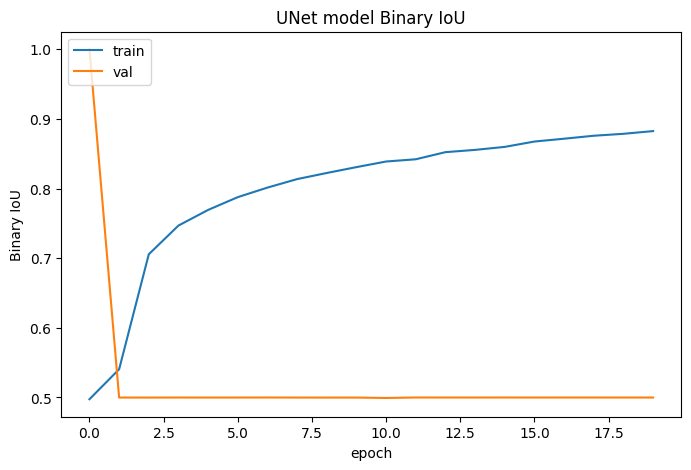

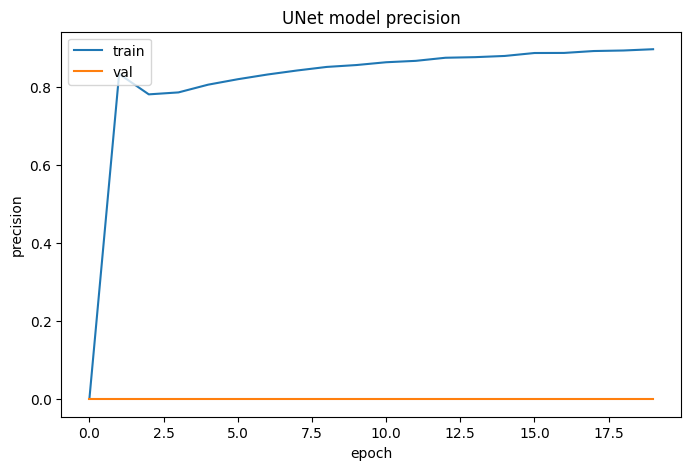

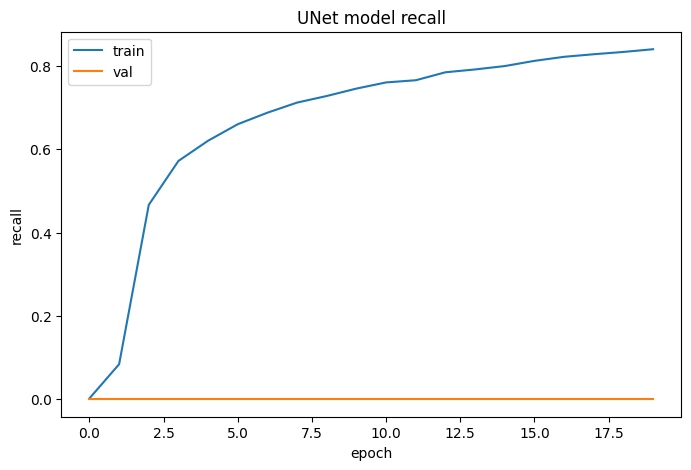

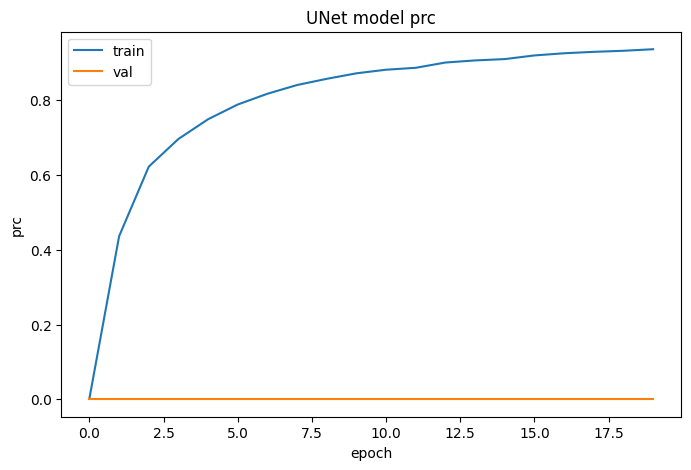

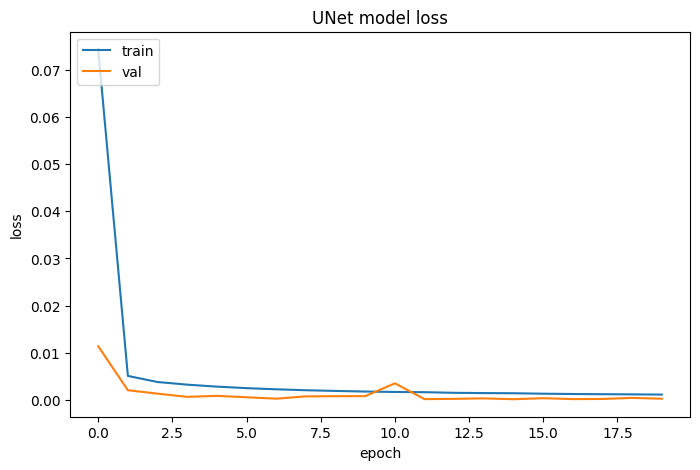

In [181]:
def plot_model_history(model_history, model_name = 'NoName', paramlst = ["Binary IoU","loss"]):
  for param in paramlst:
    plt.figure(param, figsize=(8,5))
    plt.plot(model_history.history[f"{param}"])
    plt.plot(model_history.history[f"val_{param}"])
    plt.title(f'{model_name} model {param}')
    plt.ylabel(f'{param}')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
  return 1

plot_model_history(model_history_unet, "UNet", paramlst = ["Binary IoU","precision","recall","prc","loss"])

[Back to top of: Building U-Net like model](#scrollTo=Qq29-jIug7uY)

[Back to top](#scrollTo=DoWRBGFU2AFV&line=1&uniqifier=1)

### Second model - Unused 
(but tested nonetheless)

Another U-Net-like model. This one is from Keras documentation \
Based on: https://keras.io/examples/vision/oxford_pets_image_segmentation/

In [182]:
def get_model_kerasDoc():
    # initial_bias = np.log([n_True/n_False]) # Added bias, didn't do anything, probably implemented it wrong
    # output_bias = tf.keras.initializers.Constant(initial_bias)
    
    inputs = keras.Input(shape=(*im_shape,1))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 3, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 3, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    # outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same",bias_initializer=output_bias)(x) # NOTE added bias
    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
    # Define the model
    model = keras.Model(inputs, outputs)
    return model


## Free up RAM in case the model definition cells were run multiple times
# keras.backend.clear_session()

# Build model - Muted

# model_kerasDoc = get_model_kerasDoc()
# model_kerasDoc.summary()

Same metrics as above, compile


In [183]:
# METRICS defined the same above
# METRICS = [
#       keras.metrics.TruePositives(name='tp'), # Scratch
#       keras.metrics.FalsePositives(name='fp'), # Inking
#       keras.metrics.TrueNegatives(name='tn'), # Good die
#       keras.metrics.FalseNegatives(name='fn'), # Missed scratch
#       keras.metrics.BinaryAccuracy(name='accuracy'), # Not so informative in this task 
#       keras.metrics.Precision(name='precision'), # precision = tp / (tp+fp) == how many predicted scratches are actually scratches
#       keras.metrics.Recall(name='recall'), # recall = tp / (tp + fn) == how many scratches were actually found
#       keras.metrics.AUC(name='auc'), # auc curve fpr tpr
#       keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
#       keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5, name = "Binary IoU")] # IoU = tp / (tp + fp + fn)

# model_kerasDoc.compile(optimizer=tf.keras.optimizers.Adam(),
#                        loss=keras.losses.BinaryCrossentropy(),
#                        metrics=METRICS)                                   

Fit the model

In [184]:
# FULL_LENGTH = len(x_train)

# NUM_EPOCHS = 10
# BATCH_SIZE = 48

# # class_weight = {0: 1., 1: 50.} # Doesn't work on images

# x_full = np.asarray(x_train).reshape(FULL_LENGTH, *(im_shape), 1)
# y_full = np.asarray(y_train).reshape(FULL_LENGTH, *(im_shape), 1)

# model_history_kerasDoc = model_kerasDoc.fit(x_full,y_full,
#                                             epochs = NUM_EPOCHS,
#                                             batch_size = BATCH_SIZE,
#                                             validation_split = 0.25)

In [185]:
# # Creates a SavedModel folder 'model_kerasDoc'.
# model_kerasDoc.save("/content/drive/MyDrive/model_kerasDoc")

# # Model reconstruction
# model_kerasDoc_copy = keras.models.load_model("/content/drive/MyDrive/model_kerasDoc")

Plotting model history

In [186]:
# plot_model_history(model_history_kerasDoc, "UNet - Keras")

[Back to top of: Building U-Net like model](#scrollTo=Qq29-jIug7uY)

[Back to top](#scrollTo=DoWRBGFU2AFV&line=1&uniqifier=1)

## Final Model Evaluation

Last epoch results

In [187]:
df_model_eval = np.round(pd.DataFrame({"Model Name":"U-Net-Like Model",
                                        "Binary IoU":model_history_unet.history["Binary IoU"],
                                        "Recall":model_history_unet.history["recall"][-1],
                                        "Precision":model_history_unet.history["precision"][-1],
                                        "PRC":model_history_unet.history["prc"][-1],
                                        "AUC":model_history_unet.history["auc"][-1]
                                        }),3).iloc[-1,:]
print(df_model_eval)

Model Name    U-Net-Like Model
Binary IoU               0.882
Recall                    0.84
Precision                0.896
PRC                      0.937
AUC                      0.997
Name: 19, dtype: object


Notable evaluation metrics for this task:
- Precision = tp / (tp+fp) == how many predicted scratches are actually scratches

- Recall = tp / (tp + fn) == how many scratches were actually found

- Binary IoU (Intersection-Over-Union) = tp / (tp + fp + fn) 

- AUC of ROC curve (tpv vs fpr)

- AUC of PRC curve (precision vs recall)

[Back to top](#scrollTo=DoWRBGFU2AFV&line=1&uniqifier=1)

# Additional Thoughts

**Notes and Thoughts:**
- Scratches are seen as elongated clusters of bad dies that have a high aspect ratio, meaning they are relatively thin and long compared to their width. \
This note is important for working on the problem using "Traditional Image Processing", such as mathematical morphology, as described in the bulletin below:
- Use open/close or dilation/erosion == mathematical morphology? a few structuring elements (/ \ _ |) and combine/average the results? NON-ML solution

- Scratches may not always be continuous, so sometimes there may be good dies within the scratch. These good dies are often marked for removal in a manual process called "Inked dies".

- Should I ignore low yield wafers in the test set? What can I define as "low yield" (threshold = 0.9?)?

- Can I normalise the images sizes?  Should I? 
  - To not lose location information, or 
  - increasing the inking/missing part of a scratch if the width of a scratch or the scratch itself if the dimensions get distorted, or even
  - missing the scratch location by a few pixels 

- This problem cannot/preferably not be solved/approached to as a tabular problem. \
  Transforming it to a binary image segmentation problem may be better.

- Semantic segmentation, FCN / CNN, further research showed that maybe U-Net will be good here

- Training a NNET on images require uniform sizes, I have two options:
  - Cutting the images to smaller images
  - Padding with zeros, technicaly - padding with "not IsGoodDie" bool values. 

  It doesn't realy matter whether the padding is included or not, I'll not be retrieving any of the added pixel as they do not exist in the original dataset. I'd rather choose the padding option here.



**Problems:**

- Need to improve model results

- Validation data during model fit seems off, someting went wrong, though the model did in-fact trained and learned to identify scratches.

**Model can be improved by:**
- Finding the best hyperparameter
- Changing/Tuning the arcitecture
- Further testing on attending to the imbalance in the dataset
- More preprocessing: can use mathematical morphologies with diagonal/vertical/horizontal(thin) structering elements on the wafer images to reduce noise but not not delete scratches. \
This can be risky as I described above, but would've been worth trying if I had more time.

[Back to top](#scrollTo=DoWRBGFU2AFV&line=1&uniqifier=1)

# Making Predictions

In [189]:
def predict_n_create_IsScratchDie(df_wafers_test,unet_model):
  
  x_test_set = transform_dataset(df_wafers_test, isTrain = False)
  print('Shape of x_test_set is:', np.shape(x_test_set))

  TEST_LENGTH = len(x_test_set)
  test_set_full = np.asarray(x_test_set).reshape(TEST_LENGTH, *(128,128), 1)

  pred = np.round(unet_model.predict(test_set_full)).astype(bool)
  
  IsScratchDie = []

  grps = df_wafers_test.groupby('WaferName', sort = False)
  im_number_idx = 0

  for grp in grps.groups:
      sub_df_test = grps.get_group(grp)
      
      for dx,dy in zip(sub_df_test["DieX"],sub_df_test["DieY"]):
        IsScratchDie.append(pred[im_number_idx,dx,dy,0])

      im_number_idx += 1

  return IsScratchDie

Transforming the predicted images to the DataFrame column "IsScratchDie" and creating the .csv file

In [190]:
IsScratchDie = predict_n_create_IsScratchDie(df_wafers_test,unet_model)
df_wafers_test['IsScratchDie'] = IsScratchDie
# df_wafers_test.to_csv('/content/drive/MyDrive/df_wafers_test_with_preds.csv')
df_wafers_test.to_csv('df_wafers_test_with_preds.csv')

Test set was transformed
Shape of x_test_set is: (439, 128, 128)
14/14 [==============================] - 2s 105ms/step


See results using the given helper function

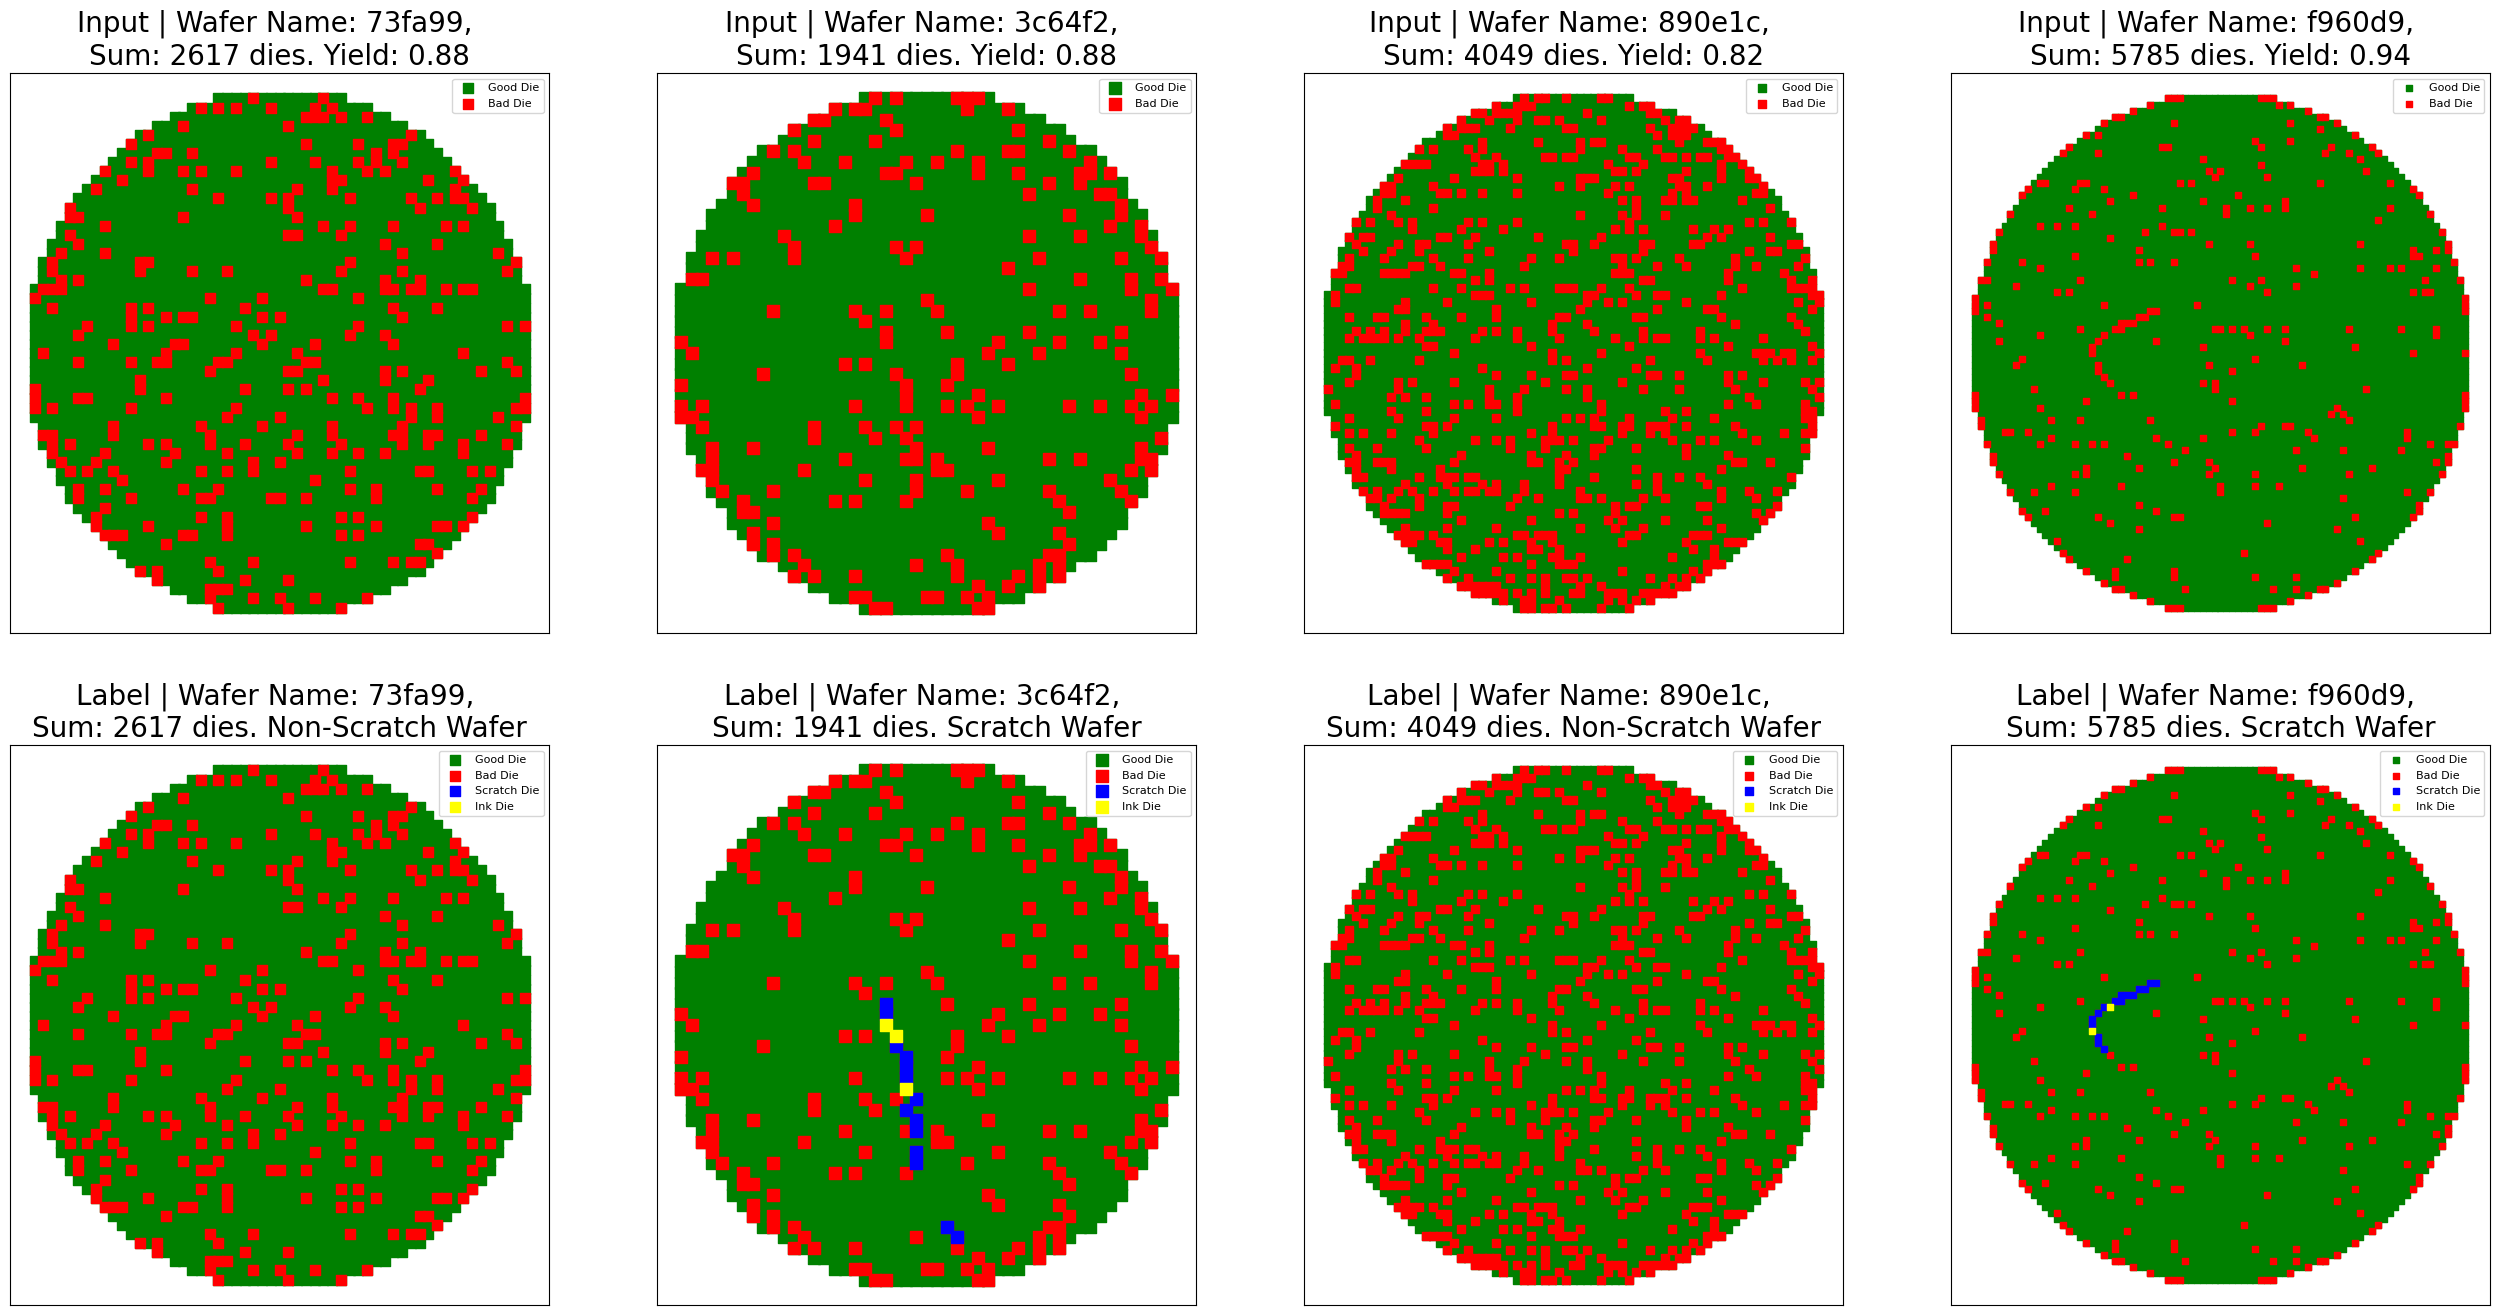

In [191]:
n_samples = 4
list_sample_results = [df_wafers_test.groupby('WaferName').get_group(group) for group in df_wafers_test['WaferName'].value_counts().sample(n_samples).index]
plot_wafer_maps(list_sample_results, figsize = 8, labels = True)

[Back to top](#scrollTo=DoWRBGFU2AFV&line=1&uniqifier=1)